In [27]:
from Data_interpret.GroundTruth import ReadMat
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import sys

from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from information_scores import *
import os
import scipy.io
import pandas as pd
from scipy.io import loadmat
from pathlib import Path
import math
from scipy.misc import derivative
from scipy import signal
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

In [3]:
# Loading DATA
train_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-08-19-16-02_5sec.mat"
train_file2 = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-13-01-42_10sec.mat"
train_data = ReadMat(train_file)
train_data2 = ReadMat(train_file2)
# train_data = ReadMat(train_file2)
test_file = "../Raw_data/8_8_2019 to 8_12_2019/2019-08-09-12-49-56_7sec.mat"
test_data = ReadMat(test_file)

# SAMPLING DATA
sample_size = 100  # sampling of raw data
train_state_traj, train_action_traj = train_data.sampled_mocap_data(sample_size)  # state X time, number of actions X time
train_state_traj2, train_action_traj2 = train_data2.sampled_mocap_data(sample_size)  # state X time, number of actions X time
test_state_traj, test_action_traj = test_data.sampled_mocap_data(sample_size)

In [30]:
# SINDy Function Definitions

def build_library(X,Y):
    
    # obtain size of state space
    l = X.shape[0]
    n = X.shape[1]
    m = Y.shape[1]
    
    # add in a constant by making a column of ones
    Theta = np.ones((l,1))
    function_label = ['1']
    
    # add in first order polynomials of all the states
    for i in range(n):
        state = np.array([X[:,i]]).T
        Theta = np.append(Theta,state,axis=1)
        function_label.append('x'+str(i))
    
    # add in sines of all states 
    for i in range(n):
        sine_state = np.array([np.sin(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('sin x'+str(i))
        
    # add in cosines of all states  
    for i in range(n):
        sine_state = np.array([np.cos(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('cos x'+str(i))
        
    # add in tangents of all states  
    for i in range(n):
        sine_state = np.array([np.tan(X[:,i])]).T
        Theta = np.append(Theta,sine_state,axis=1)
        function_label.append('tan x'+str(i))
        
    
    # add in controls
    for i in range(m):
        control = np.array([Y[:,i]]).T
        Theta = np.append(Theta,control,axis=1) 
        function_label.append('u'+str(i))
 
    return Theta,function_label

# def Sparse_Regression(Theta,dXdt,thresh):
    
#     lassoreg = Lasso(alpha=thresh,normalize=True, max_iter=1e5) # sparsify!!!!! Hell yeah!!!
#     lassoreg.fit(Theta,dXdt)
#     Xi = lassoreg.coef_
    
#     return Xi.T

def Sparse_Regression(Theta,dXdt,thresh):
    
    elasticreg = ElasticNet(alpha=thresh, random_state = 0) # sparsify!!!!! Hell yeah!!!
    elasticreg.fit(Theta,dXdt)
    Xi = elasticreg.coef_
    
    return Xi.T


In [46]:
dt = 0.01 # sampling time in seconds

X = train_state_traj2.T
Y = train_action_traj2.T
dX = np.zeros((X.shape[0]-4))

for i in range(X.shape[1]):
    Xi = X[:,i]
    dXi = (1/(12*dt)) * (-Xi[4:] + 8*Xi[3:-1] - 8*Xi[1:-3] + Xi[:-4])
    Xi = Xi[2:-2]
    dX = np.vstack([dX,dXi])

Y = Y[2:-2,:] # final output values
X = X[2:-2,:] # final state values
Xprime = dX[1:,:].T # state derivatives


print(Y.shape,X.shape,Xprime.shape) # print out the shapes of the data matrices as a sanity check

Theta,function_label = build_library(X,Y) # build the lbrary of functions (Theta)
threshold = 0.001 # thresholding paramater for sparsification
Xi = Sparse_Regression(Theta,Xprime,threshold) # obtain Xi ("ksi") that gives us the coefficients
Xi = np.asarray(Xi)
print(Xi.shape)

(1052, 3) (1052, 9) (1052, 9)
(40, 9)


In [47]:
states = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']
df = pd.DataFrame(Xi,index = function_label, columns = states)
A = df.head(40)
A

,x1,x2,x3,x4,x5,x6,x7,x8,x9
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
x0,-0.299513,-0.288387,-2.245417,0.643280,0.376194,11.162630,84.868079,118.420355,14.005859
x1,1.114369,-2.598592,2.437833,-0.691431,-0.317305,8.849924,-141.464840,-23.033339,0.308116
x2,0.543087,-1.792925,0.333605,0.528831,-0.695843,-4.719694,7.719208,-44.116494,7.043604
x3,0.193301,-4.942815,1.681092,-1.574584,1.321257,-0.000000,-79.493818,45.895927,3.065049
x4,3.474521,-0.171357,0.682939,0.000000,-0.072612,-6.048206,-30.495291,-108.091945,-8.186531
x5,0.015448,-0.007677,-0.203152,0.083365,-0.086348,-0.976863,13.147229,-1.882301,-0.358160
x6,-0.120099,0.356291,-0.358742,0.955101,-0.050433,-0.742356,14.275623,2.178621,1.517037
x7,0.040485,0.114395,-0.103841,0.156377,0.925181,1.315014,16.484373,13.484502,1.683635
x8,0.007940,0.047143,0.032903,0.051018,0.153631,-0.576631,-2.188006,-1.334120,0.740941


In [48]:
def RoboFly_dynamics(t,X,u,Xi):
    # extract control inputs
    u0 = u[0]; u1 = u[1]; u2 = u[2]
    # extract states
    x0 = X[0];x1 = X[1];x2 = X[2];x3 = X[3];x4 = X[4];x5 = X[5]
    x6 = X[6];x7 = X[7];x8 = X[8]
    # define library
    library = (np.array([1,x0,x1,x2 ,x3,x4,x5,x6,x7,x8, np.sin(x0),np.sin(x1),np.sin(x2),np.sin(x3),np.sin(x4),np.sin(x5),
             np.sin (x6),np.sin(x7),np.sin(x8),np.cos(x0),np.cos(x1),np.cos(x2),np.cos(x3),np.cos(x4),np.cos(x5),np.cos(x6),
                np.cos (x7),np.cos(x8),np.tan(x0),np.tan(x1),np.tan(x2),np.tan(x3),np.tan(x4),np.tan(x5),np.tan(x6),np.tan(x7),np.tan(x8),
            u0,u1,u2]))
    # obtain the state equations
    dXdt = np.dot(Xi.T,library)
    
    #unpack states
    x0dot = dXdt[0]; x1dot = dXdt[1]; x2dot = dXdt[2]; x3dot = dXdt[3]; x4dot = dXdt[4]; x5dot = dXdt[5];
    x6dot = dXdt[6]; x7dot = dXdt[7]; x8dot = dXdt[8];
        

    return [x0dot, x1dot, x2dot, x3dot, x4dot, x5dot, x6dot, x7dot, x8dot]

In [3]:
# define number of iterations (usually the number of control inputs)
num_iter = X.shape[0]
# initial condition
initial_state = np.array([X[0,:]]).T
u = np.array([Y[0,:]]).T

# place holder for trajectory
predicted_trajectory = []

# intialize time values
initial_time = 0
final_time = dt
# Eveolve the ODE (as told by SINDYc) in time
for i in range(num_iter-1):
    # reshape initial states
    initial_state = initial_state.reshape(9,)
    # define timespan for ODE time stepping
    tspan = np.linspace(initial_time,final_time,3)
    # forward propagation
    next_state = odeint(RoboFly_dynamics,tspan,initial_state , args = (u,Xi))
    next_state = next_state[-1,:] # grab the latest evolved trajectory
    # collect states
    predicted_trajectory.append(next_state)
    # update state
    initial_state = next_state
    # update control action
    u = Y[i+1,:] 
    # update time vectors
    initial_time = final_time
    final_time = final_time + dt
    
predicted_trajectory = np.asarray(predicted_trajectory)

NameError: name 'X' is not defined

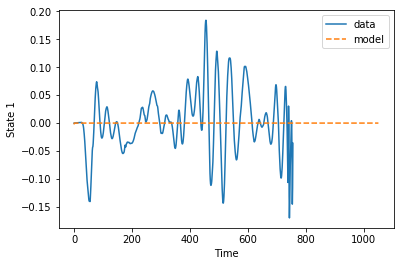

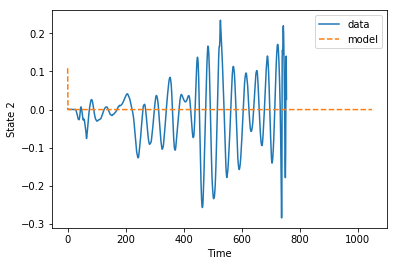

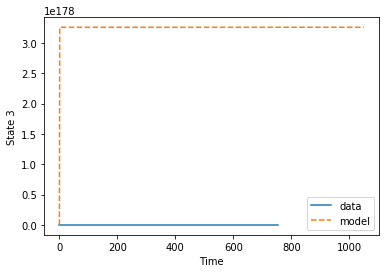

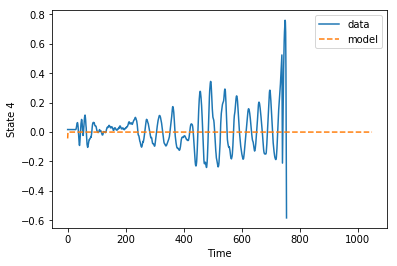

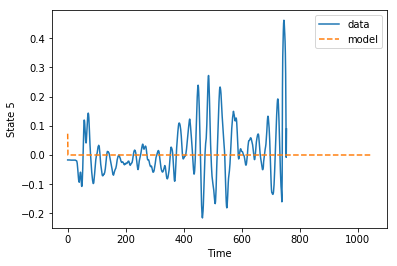

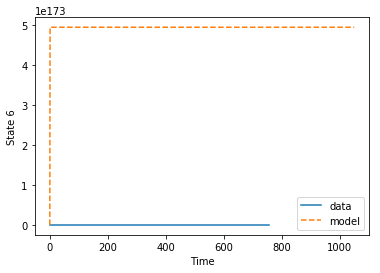

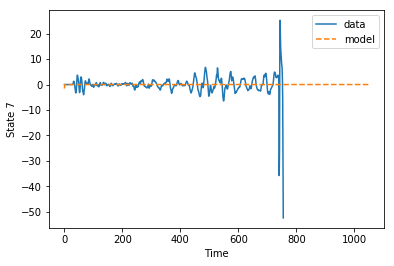

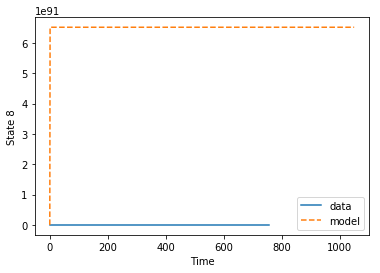

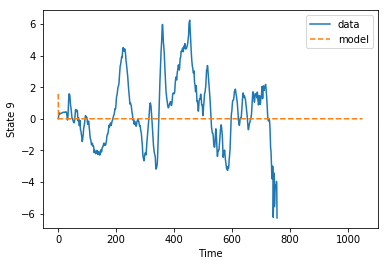

In [54]:
for i in range(9):
    plt.plot(test_state_traj[i,:],label ='data')
    plt.plot(predicted_trajectory[:,i],label = 'model', linestyle='--')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('State '+str(i+1))
    plt.show()